add accuracy plots

In [4]:
from TimeSformer.timesformer.models.vit import TimeSformer

In [5]:
model = TimeSformer(img_size=32, num_classes=2, num_frames=60, attention_type='divided_space_time', pretrained_model='./modelZoo/K400-96.pyth')

In [6]:
import torch
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
IMG_SIZE = 32

In [9]:
def frames_from_video_file(video_path, MAX_SEQ_LENGTH, frame_step, output_size = (IMG_SIZE, IMG_SIZE)):
    result = []
  
    src = cv2.VideoCapture(str(video_path))  

    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

    need_length = 1 + (MAX_SEQ_LENGTH - 1) * frame_step

    if need_length > video_length:
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    frame = cv2.resize(frame, output_size)
    result.append(frame)

    for _ in range(MAX_SEQ_LENGTH - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = cv2.resize(frame, output_size)
            result.append(frame)
        else:
            frame = np.zeros_like(result[0])
            result.append(frame)
    src.release()
    result = np.array(result)
    return result

In [10]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, df, root_dir, MAX_SEQ_LENGTH, frame_step):
        self.video_paths = df["video-name"].values.tolist()
        self.labels = df["label"].values.tolist()
        self.n_frames = MAX_SEQ_LENGTH
        self.root_dir = root_dir
        self.frame_step = frame_step
        
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = self.labels[idx]
        frames = frames_from_video_file(os.path.join(self.root_dir, path), self.n_frames, self.frame_step)
        frames = np.float32(frames)
        frames = np.moveaxis(frames, -1, 0)
        return frames, label

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv("../data/mirror-data.csv")
df["Action"] = df["Action"].str.rstrip()
df = df[df.Action != "Talking&Yawning"]
df = df[df.Action != "Talking"]
df["label"] = (df["Action"]=="Yawning")
df["label"] = df["label"].astype("int")

In [13]:
df.head()

,Action,video-name,label
0,Normal,1-FemaleNoGlasses-Normal.avi,0
2,Yawning,1-FemaleNoGlasses-Yawning.avi,1
3,Normal,2-FemaleNoGlasses-Normal.avi,0
5,Yawning,2-FemaleNoGlasses-Yawning.avi,1
6,Normal,3-FemaleGlasses-Normal.avi,0


In [14]:
i = 0
dfTrain = pd.DataFrame()
dfTest = pd.DataFrame()

while i<len(df):
    if i%5==0:
        dfTest = pd.concat([dfTest, df.iloc[[i]]])
    else :
        dfTrain = pd.concat([dfTrain, df.iloc[[i]]])
    i+=1

In [15]:
print(dfTest[dfTest.label == 0].shape[0])
print(dfTest[dfTest.label == 1].shape[0])

22
20


In [37]:
MAX_SEQ_LENGTH = 30
frame_step = 10

In [31]:
train_ds = VideoDataset(dfTrain, "../data/YawDD/YawDD dataset/Mirror/all/", MAX_SEQ_LENGTH, frame_step)
test_ds = VideoDataset(dfTest, "../data/YawDD/YawDD dataset/Mirror/all/", MAX_SEQ_LENGTH, frame_step)

In [32]:
from torch.utils.data import DataLoader

In [33]:
train_loader = DataLoader(train_ds, batch_size=1)
val_loader = DataLoader(test_ds, batch_size=1)

In [34]:
import torch.optim as optim
from torch import nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [35]:
model.to(device)

TimeSformer(
  (model): VisionTransformer(
    (dropout): Dropout(p=0.0, inplace=False)
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (time_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
        )
        (temporal_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (temporal_attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
   

In [36]:
num_epochs = 2
train_accuracies = []
val_accuracies = []

def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)

    # Calculate training accuracy for the epoch
    train_acc_epoch = 100 * running_acc / len(train_loader)
    train_accuracies.append(train_acc_epoch)

    # Evaluate on validation set
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        val_accuracies.append(val_acc)

    print('[%d] loss: %.3f, train_acc: %.3f, val_acc: %.3f' %
          (epoch + 1, running_loss / len(train_loader), train_acc_epoch, val_acc))

[1] loss: 0.734, train_acc: 34.756, val_acc: 47.619
[2] loss: 0.697, train_acc: 42.073, val_acc: 50.000


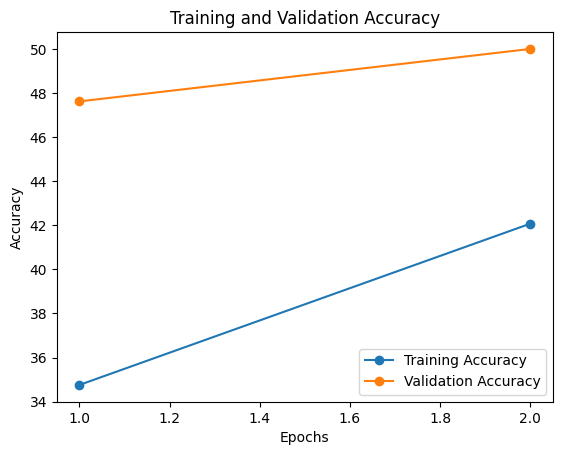

In [39]:
import torch
import matplotlib.pyplot as plt

# Plotting
epochs_range = range(1, num_epochs + 1)

# Plotting training accuracy
plt.plot(epochs_range, [acc.cpu().numpy() for acc in train_accuracies], label='Training Accuracy', marker='o')

# Plotting validation accuracy
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Adding a legend
plt.legend()

# Save the plot as a JPEG file
plt.savefig('accuracy_plot.jpeg')

In [ ]:
#torch.save(model, "./savedModel/test.pth")